In [1]:
%pip install agentpy 

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Model Design
import agentpy as ap 
import numpy as np 
import pandas as pd
from boids_model import BoidsModel

# Visualisation
from visualisation import animation_plot, animation_plot_single
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split


In [3]:
results = ap.DataDict.load('BoidsModel')

Loading from directory ap_output/BoidsModel_1/
Loading parameters_sample.csv - Successful
Loading parameters_constants.json - Successful
Loading reporters.csv - Successful
Loading info.json - Successful
Loading variables_BoidsModel.csv - Successful
Loading parameters_log.json - Successful


In [25]:
X =  results.reporters[['cohesion_strength', 'seperation_strength', 'alignment_strength', 'border_strength']]
Y = results.reporters[['final_alignment', 'final_cohesion', 'final_separation_avg', 'final_border_distance_avg']]

In [32]:
from sklearn.preprocessing import StandardScaler

# Split the data into training+validation set and test set
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Split the training+validation set into separate training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.25, random_state=42)

# # Convert the datasets to PyTorch tensors
# X_train = torch.tensor(X_train.values, dtype=torch.float32)
# Y_train = torch.tensor(Y_train.values, dtype=torch.float32)
# X_val = torch.tensor(X_val.values, dtype=torch.float32)
# Y_val = torch.tensor(Y_val.values, dtype=torch.float32)
# X_test = torch.tensor(X_test.values, dtype=torch.float32)
# Y_test = torch.tensor(Y_test.values, dtype=torch.float32)

# Convert pandas dataframes to numpy arrays (if not already in numpy format)
X_train_np = X_train.values
Y_train_np = Y_train.values
X_val_np = X_val.values
Y_val_np = Y_val.values
X_test_np = X_test.values
Y_test_np = Y_test.values

# Initialize scalers for X and Y
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler_X.fit_transform(X_train_np)
Y_train_scaled = scaler_Y.fit_transform(Y_train_np)

# Transform the validation and test data
X_val_scaled = scaler_X.transform(X_val_np)
Y_val_scaled = scaler_Y.transform(Y_val_np)
X_test_scaled = scaler_X.transform(X_test_np)
Y_test_scaled = scaler_Y.transform(Y_test_np)

# Convert the numpy arrays back to PyTorch tensors
X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
Y_train = torch.tensor(Y_train_scaled, dtype=torch.float32)
X_val = torch.tensor(X_val_scaled, dtype=torch.float32)
Y_val = torch.tensor(Y_val_scaled, dtype=torch.float32)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)
Y_test = torch.tensor(Y_test_scaled, dtype=torch.float32)

In [33]:
print(X_train)

tensor([[-0.8931,  1.3775, -1.3699, -1.3621],
        [-0.8931,  0.2505, -1.3699, -1.3621],
        [ 0.2917, -1.1584,  0.4063,  1.2759],
        [ 1.6082,  0.2505,  1.2945, -1.3621],
        [-0.8931,  0.2505,  0.4063,  1.2759],
        [ 1.6082, -0.8766, -1.3699,  0.3966],
        [-0.8931, -1.1584,  1.2945, -0.4828],
        [ 1.6082, -1.1584,  0.4063,  0.3966],
        [ 0.2917,  1.3775,  1.2945,  1.2759],
        [-0.7615,  0.2505, -0.4818, -1.3621],
        [ 0.2917,  0.2505, -1.3699, -1.3621],
        [ 1.6082, -1.1584, -1.3699,  0.3966],
        [-0.8931, -1.1584, -0.4818, -0.4828],
        [ 1.6082,  0.2505, -1.3699, -0.4828],
        [ 0.2917,  0.2505, -1.3699,  0.3966],
        [ 0.2917,  0.2505,  1.2945,  1.2759],
        [-0.8931, -1.1584,  1.2945, -1.3621],
        [ 0.2917, -0.8766,  1.2945,  1.2759],
        [ 0.2917,  1.3775,  1.2945, -1.3621],
        [ 1.6082,  0.2505, -0.4818, -0.4828],
        [ 1.6082,  1.3775,  0.4063,  1.2759],
        [-0.7615,  0.2505,  0.4063

In [34]:
print(Y_train)

tensor([[ 0.6064,  2.3534,  2.3648, -2.2860],
        [ 0.6093,  2.5588,  2.5555, -2.5257],
        [-0.7247, -1.5506, -1.5504,  0.9622],
        [ 0.6094, -0.0481, -0.0557,  0.7119],
        [ 0.6097,  0.3531,  0.3373,  0.2014],
        [ 0.5933, -0.9169, -0.9055,  1.7902],
        [ 0.4875, -0.8594, -0.8722,  0.0059],
        [-2.5053, -1.7949, -1.8025,  0.7928],
        [ 0.5914,  0.3965,  0.3929,  0.1678],
        [ 0.5928,  1.5841,  1.6525, -1.6269],
        [ 0.6007,  1.0770,  1.1095, -0.6213],
        [ 0.6092, -1.4884, -1.4853,  0.7059],
        [ 0.3594, -1.1930, -1.1768, -0.8235],
        [ 0.6029,  0.0469,  0.0495,  0.6199],
        [ 0.6042,  0.3156,  0.3247,  0.3093],
        [ 0.5663,  0.1211,  0.1188,  0.5008],
        [-1.0119, -0.8606, -0.8698, -0.7888],
        [-1.9119, -0.9849, -0.9873,  1.2607],
        [ 0.6085,  1.1301,  1.1293, -0.7032],
        [ 0.6024, -0.1692, -0.1583,  0.9260],
        [ 0.5992,  0.1380,  0.1306,  0.5071],
        [ 0.0619,  0.8050,  0.8038

In [35]:
# Neural Network Architecture
class Net(nn.Module):
    def __init__(self, X, Y):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X.size(1), 128)  # Input layer to 128 neurons
        self.fc2 = nn.Linear(128, 64)         # Hidden layer (128 to 64 neurons)
        self.fc3 = nn.Linear(64, 32)   # Hidden layer (64 to 32 neurons)
        self.fc4 = nn.Linear(32, Y.size(1))   # Output layer (32 to number of target features)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  # No activation function in the output layer
        return x

In [36]:
model = Net(X_train, Y_train)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Training loop
for epoch in range(1000):  # Number of epochs
    optimizer.zero_grad()   # Zero the gradient buffers
    output = model(X_train)         # Pass the batch through the network
    loss = criterion(output, Y_train)  # Compute the loss
    loss.backward()         # Backpropagation
    optimizer.step()        # Update weights

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluate the model with test data (if available)

Epoch 1, Loss: 1.0204970836639404
Epoch 101, Loss: 0.09919644892215729
Epoch 201, Loss: 0.05586835369467735
Epoch 301, Loss: 0.025722553953528404
Epoch 401, Loss: 0.010601760819554329
Epoch 501, Loss: 0.004881138447672129
Epoch 601, Loss: 0.0023725428618490696
Epoch 701, Loss: 0.0017910548485815525
Epoch 801, Loss: 0.001424604095518589
Epoch 901, Loss: 0.002041558502241969


In [37]:
# Assuming 'model' is your trained model and 'loss_fn' is your loss function
model.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Do not calculate gradients to save memory
    # Calculate the predictions for the test set
    Y_pred = model(X_test)

    # Calculate the loss for the test set
    test_loss = criterion(Y_pred, Y_test)

print(f'Test loss: {test_loss.item()}')

Test loss: 0.7303500771522522


In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate the predictions for the test set
Y_pred = model(X_test)

# Convert the predictions and true values to NumPy arrays
Y_pred_np = Y_pred.detach().numpy()
Y_test_np = Y_test.numpy()

# Calculate the metrics
mae = mean_absolute_error(Y_test_np, Y_pred_np)
mse = mean_squared_error(Y_test_np, Y_pred_np)
r2 = r2_score(Y_test_np, Y_pred_np)

print(f'MAE: {mae}, MSE: {mse}, R^2: {r2}')

MAE: 0.4313850998878479, MSE: 0.7303500771522522, R^2: 0.24316725830029742


/Users/pedrosousa/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pedrosousa/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pedrosousa/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pedrosousa/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: Mat

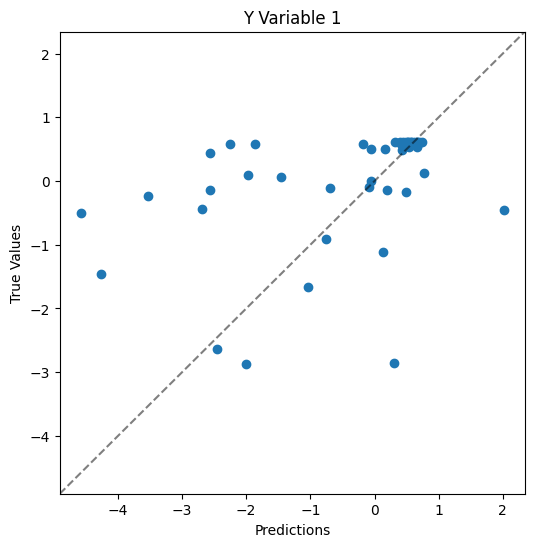

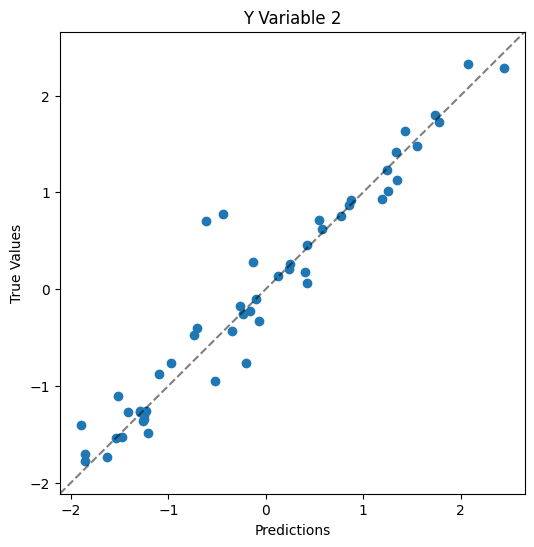

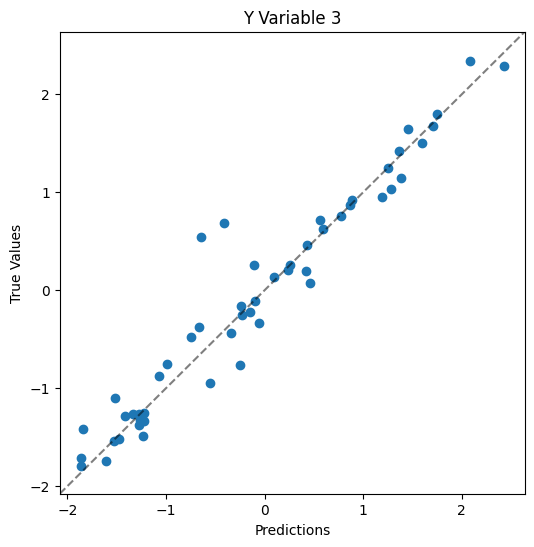

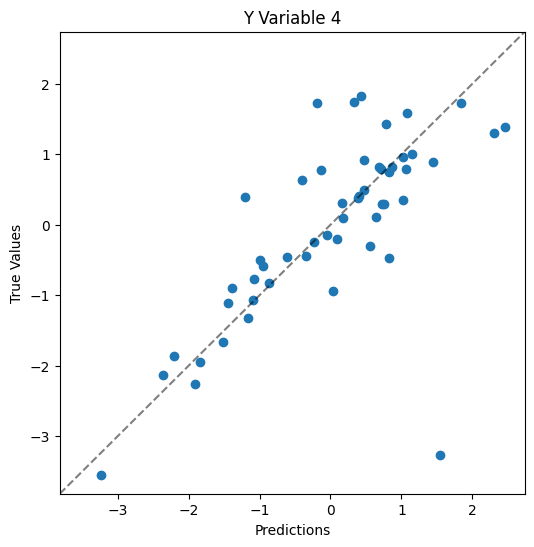

In [39]:
import matplotlib.pyplot as plt

# Assuming Y_test_np and Y_pred_np are 2D arrays with 4 columns each
for i in range(4):
    plt.figure(figsize=(6, 6))
    plt.scatter(Y_pred_np[:, i], Y_test_np[:, i])
    plt.xlabel('Predictions')
    plt.ylabel('True Values')
    plt.title(f'Y Variable {i+1}')

    # Add a diagonal line
    limits = [np.min([plt.xlim(), plt.ylim()]),  # Find the lower limit
              np.max([plt.xlim(), plt.ylim()])]  # Find the upper limit
    plt.xlim(limits)
    plt.ylim(limits)
    plt.plot(limits, limits, color='black', alpha=0.5, linestyle='--')

    plt.show()